In [1]:
import networkx as nx
import random as random
import matplotlib.pyplot as plt
import itertools
import numpy as np
from timeit import default_timer as timer
from math import ceil, floor
import copy
import pandas as pd

from mas_transportation_utils import *

## Index des variables 
G = road graph

SPL = shortest path length

range = perception/domaine de recherche

In [2]:
class Agent:
    def __init__(self, unique_id):
        self.is_alive = True
        self.unique_id = unique_id
    
    def update(self) -> None:
        pass
    
    def decide(self) -> None:
        pass
    
class UserAgent(Agent):
    def __init__(self, unique_id, v_dep, v_arr):
        super().__init__(unique_id)
        self.v_dep = v_dep
        self.v_r = v_dep
        self.v_arr = v_arr
        
        #calcul de la longueur du plus court chemin à l'origine
        self.SPL = nx.shortest_path_length(sma.G, source=self.v_dep, target=self.v_arr)
    
    def update(self) -> None:
        pass
    
    def decide(self) -> None:
        pass
        
        
        

class RiderAgent(UserAgent):
    def __init__(self, unique_id, v_dep, v_arr, detour_coef, max_wt):
        super().__init__(unique_id, v_dep, v_arr)
             
        #preferences
        self.detour_coef = detour_coef #coef max de détour
        self.max_wt = max_wt #temps d'attente max avant annulation de la demande, coef aussi ?
        
        self.l_arr_tick = sma.tick + self.SPL + int(self.SPL*detour_coef)
            
    def compute_wt_node_range(self):
        pass
        
    def update(self) -> None:
        pass
    
    def decide(self) -> None:
        pass
            

In [3]:
class DriverAgent(UserAgent):
    def __init__(self, unique_id, v_dep, v_arr, detour_coef, capacity=3):
        super().__init__(unique_id, v_dep, v_arr)
        self.c = capacity
        self.trip = nx.shortest_path(sma.G, source=self.v_dep, target=self.v_arr)
        #initialisation de la perception
        self.detour_coef = detour_coef
        self.l_arr_tick = sma.tick + self.SPL + int(self.SPL*detour_coef)
        
        #tableaux du scheduling S
        self.arr = [self.SPL]
        self.ddl = [self.l_arr_tick]
        self.slk = [self.ddl[0]-self.arr[0]]
        
        self.stops = [v_arr] #tableau référençant les noeuds avec arrêts obligatoire 
                             #(noeuds de recup et de dépot des passagers et noeud d'arrivé du conducteur)
        self.capacities = [capacity]
        self.tag_event = False
        
        self.node_ranges = [] #les ellipses
        self.node_ranges.append(self.compute_detour_node_range(self.v_dep, self.v_arr, 
                                                                self.l_arr_tick - sma.tick))
        
    def compute_detour_node_range(self, source, target, l_arr):
        #retourne les noeuds présents dans une ellipse
        paths = list(nx.all_simple_paths(sma.G, source=source, target=target, cutoff=l_arr))
        return set([item for sublist in paths for item in sublist])
        
    def compute_all_detour_node_ranges(self):
        self.node_ranges = []
        self.node_ranges.append(self.compute_detour_node_range(self.v_r, self.stops[0],
                                                           (self.arr[0] - sma.tick) + self.slk[0]))
            
        for i in range(len(self.stops)-1):
            self.node_ranges.append(self.compute_detour_node_range(self.stops[i], self.stops[i+1], 
                                                               (self.arr[i+1] - sma.tick - self.arr[i]) + self.slk[i+1]))
         
        
    def to_string(self):
        print("I am driver",self.unique_id,"- trip:",self.trip)
        
        
    def add_rider_to_scheduler(self, rider, r_v1, r_v2, dl_v1, dl_v2):
        #on ajoute le passager au scheduler, on met a jour le trip et la capacité
        
        #########checks##############
        if dl_v1 > self.ddl[-1] or dl_v2 > self.ddl[-1]:
            raise Exception("Rider's deadline should be lower than driver's deadline, subject to change for earliest departure")
            
        driver_scope = set([item for sublist in self.node_ranges for item in sublist])
        if r_v1 not in driver_scope or r_v2 not in driver_scope:
            raise Exception("Rider's nodes should be in the driver's scope")
        #############################    
            
        for i in range(len(self.ddl)) :
            if dl_v1 <= self.ddl[i] :
                self.ddl.insert(i, dl_v1)
                self.stops.insert(i, r_v1)
                if i == 0:
                    self.capacities.insert(i, self.c - 1)
                else : 
                    self.capacities.insert(i, self.capacities[i-1]-1)
                for j in range(len(self.ddl[i:])):
                    if dl_v2 <= self.ddl[j] :
                        self.ddl.insert(j, dl_v2)
                        self.stops.insert(j, r_v2)
                        self.capacities.insert(j, self.capacities[i-1]+1)
                        break
                break
                
        #puis on recalcule le chemin le plus court et la marge (skl = slack time)
        
        #pour le premier on se base sur le noeud courant
        self.arr = []
        dif = []
        
        self.arr.append(sma.tick + nx.shortest_path_length(sma.G, self.v_r, self.stops[0]))
        dif.append(self.ddl[0] - self.arr[0])
        
        for i in range(len(self.stops)-1):
            self.arr.append(self.arr[i] + nx.shortest_path_length(sma.G, self.stops[i], self.stops[i+1]))
            dif.append(self.ddl[i+1] - self.arr[i+1])
        
        #calcul marge dépendante des marges suivantes
        self.slk = []
        for i in range(len(dif)):
            self.slk.append(np.min(dif[i:]))
        
        self.tag_event = True
        
        
        
    def update(self) :
        if self.tag_event == True:
            self.compute_all_detour_node_ranges()
            self.trip = nx.shortest_path(sma.G, self.v_r, self.stops[0])
            self.tag_event = False
        else : 
            self.node_ranges[0] = [self.compute_detour_node_range(self.v_r, self.stops[0],
                                                           (self.arr[0] - sma.tick) + self.slk[0])]
        #pass
    
    def decide(self) : 
        #l'agent bouge
        #si on arrive pas au bout du subtrip, on avance
        if len(self.trip)>1:
            self.trip.pop(0)
            self.v_r = self.trip[0]
            
        #sinon il faut determiner si le conducteur est arrivé à destination ou si c'est la fin d'une étape        
        else :
            if self.trip[0] == self.v_arr :
                self.is_alive = False
                if sma.verbose == True:
                    print("Driver",self.unique_id,"arrived")
            else :
                self.v_r = self.trip[0]
                self.arr.pop(0)
                self.slk.pop(0)
                self.ddl.pop(0)
                self.capacities.pop(0)
                self.stops.pop(0)
                self.trip = nx.shortest_path(sma.G, self.v_r, self.stops[0])
                
            
        
            
        
            

# SMA
* peut être faire 3 dictionnaires d'agents : 1 avec tout les agents, 1 avec les conducteurs et 1 avec les passagers ?

In [4]:
import random
class SMA:
    def __init__(self, verbose=False):
        self.tick=0
        self.resetTicks()

        self.agentDict = {}
        self.G = None
        self.verbose = verbose
        
        self.total_number_drivers = 0
        self.total_number_riders = 0

    def resetTicks(self):
        tick=0
          
    def setRoadGraph(self,graph):
        self.G = graph
        
    def addAgent(self,ag):
        self.agentDict[ag.unique_id] = ag
 
    def run(self,rounds=None):
        if rounds==None:
            #on s'arrete si tout les passagers ou tout les conducteurs sont arrivés
            self.runOnce()
            while len([agent for agent in sma.agentDict.values() if ("RiderAgent" in agent.__class__.__name__)]) > 0 and len([agent for agent in sma.agentDict.values() if ("DriverAgent" in agent.__class__.__name__)]) > 0:
                self.runOnce()
            #print("Finished in",self.tick,"ticks")
        
        else :
            #génération classique
            for i in range(0,rounds):
                self.runOnce()

    def runOnce(self):
        self.tick+=1
        #random.shuffle(self.agentList)
        for ag in self.agentDict.values() :
            print(ag.unique_id)
            ag.update()
            ag.decide()
            
        for ag in self.agentDict.copy().values():
            if ag.is_alive == False:
                self.agentDict.pop(ag.unique_id)
                
        if self.verbose == True:      
            print("tick "+str(self.tick)+" ended")

/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


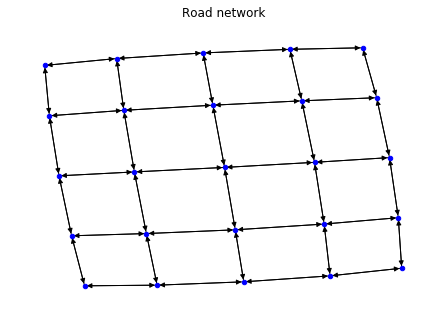

In [5]:
SIZE_MAP = 5
PER_PERTURB_MAP = 0
MAX_NB_DRIVERS = np.arange(5,500,50)
MAX_NB_RIDERS = 100
NB_RUN = 1000
SEED = [1,6,42,69,48,100,26,35,89,663,559,478,452,236,5789,555,666,777,888,999,111,222,333,444,555]
#NB_REP = len(SEED)

#riders_types=['naive','retag','retag_risky']
riders_types=['naive','retag']
results = []

G = generate_2D_graph(SIZE_MAP, coef_suppr=PER_PERTURB_MAP, show=True)

In [6]:
sma = SMA()
sma.setRoadGraph(G)
source = (1,0)
target = (3,2)
d1 = DriverAgent(1, source, target, 0)

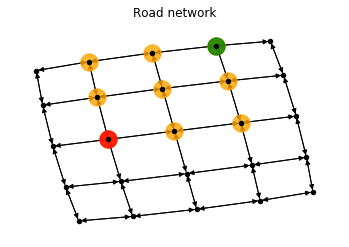

[{(1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)}]

In [7]:
print_user_perception(d1, sma.G)
d1.node_ranges

In [8]:
d1.ddl

[4]

#### Test exception 1

In [9]:
d1.add_rider_to_scheduler(None, (1,1), (1,4), 1, 5)

Exception: Rider's deadline should be lower than driver's deadline, subject to change for earliest departure

#### Test exception 2

In [10]:
d1.add_rider_to_scheduler(None, (1,1), (1,4), 1, 3)

Exception: Rider's nodes should be in the driver's scope

#### Ajout d'un conducteur

In [11]:
d1.add_rider_to_scheduler(None, (1,1), (3,1), 1, 3)
d1.stops

[(1, 1), (3, 1), (3, 2)]

In [12]:
d1.compute_all_detour_node_ranges()

In [13]:
d1.node_ranges


[{(1, 0), (1, 1)}, {(1, 1), (2, 1), (3, 1)}, {(3, 1), (3, 2)}]

In [14]:
d1.slk

[0, 0, 0]

In [15]:
d1.ddl

[1, 3, 4]

In [16]:
d1.arr

[1, 3, 4]

/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


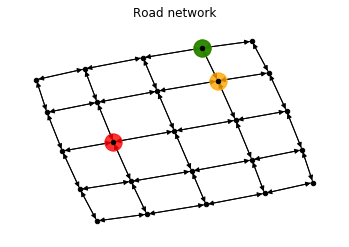

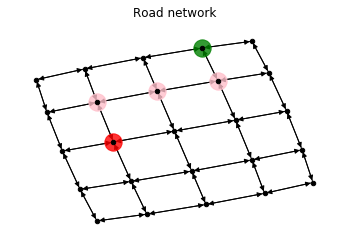

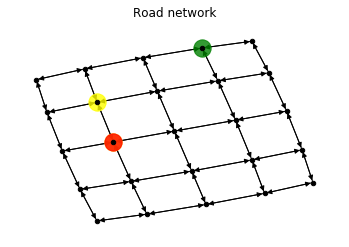

In [18]:
print_user_perception(d1, sma.G, step_by_step=True)

In [ ]:
#wt range compute example
source = (1,1)
list(nx.ego_graph(G, source, 5))

In [ ]:
paths = list(nx.all_simple_paths(G, source=source, target=target, cutoff=limit_range))
set([item for sublist in paths for item in sublist])